In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import laspy
import os
import geopandas as gpd
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize


Saved!


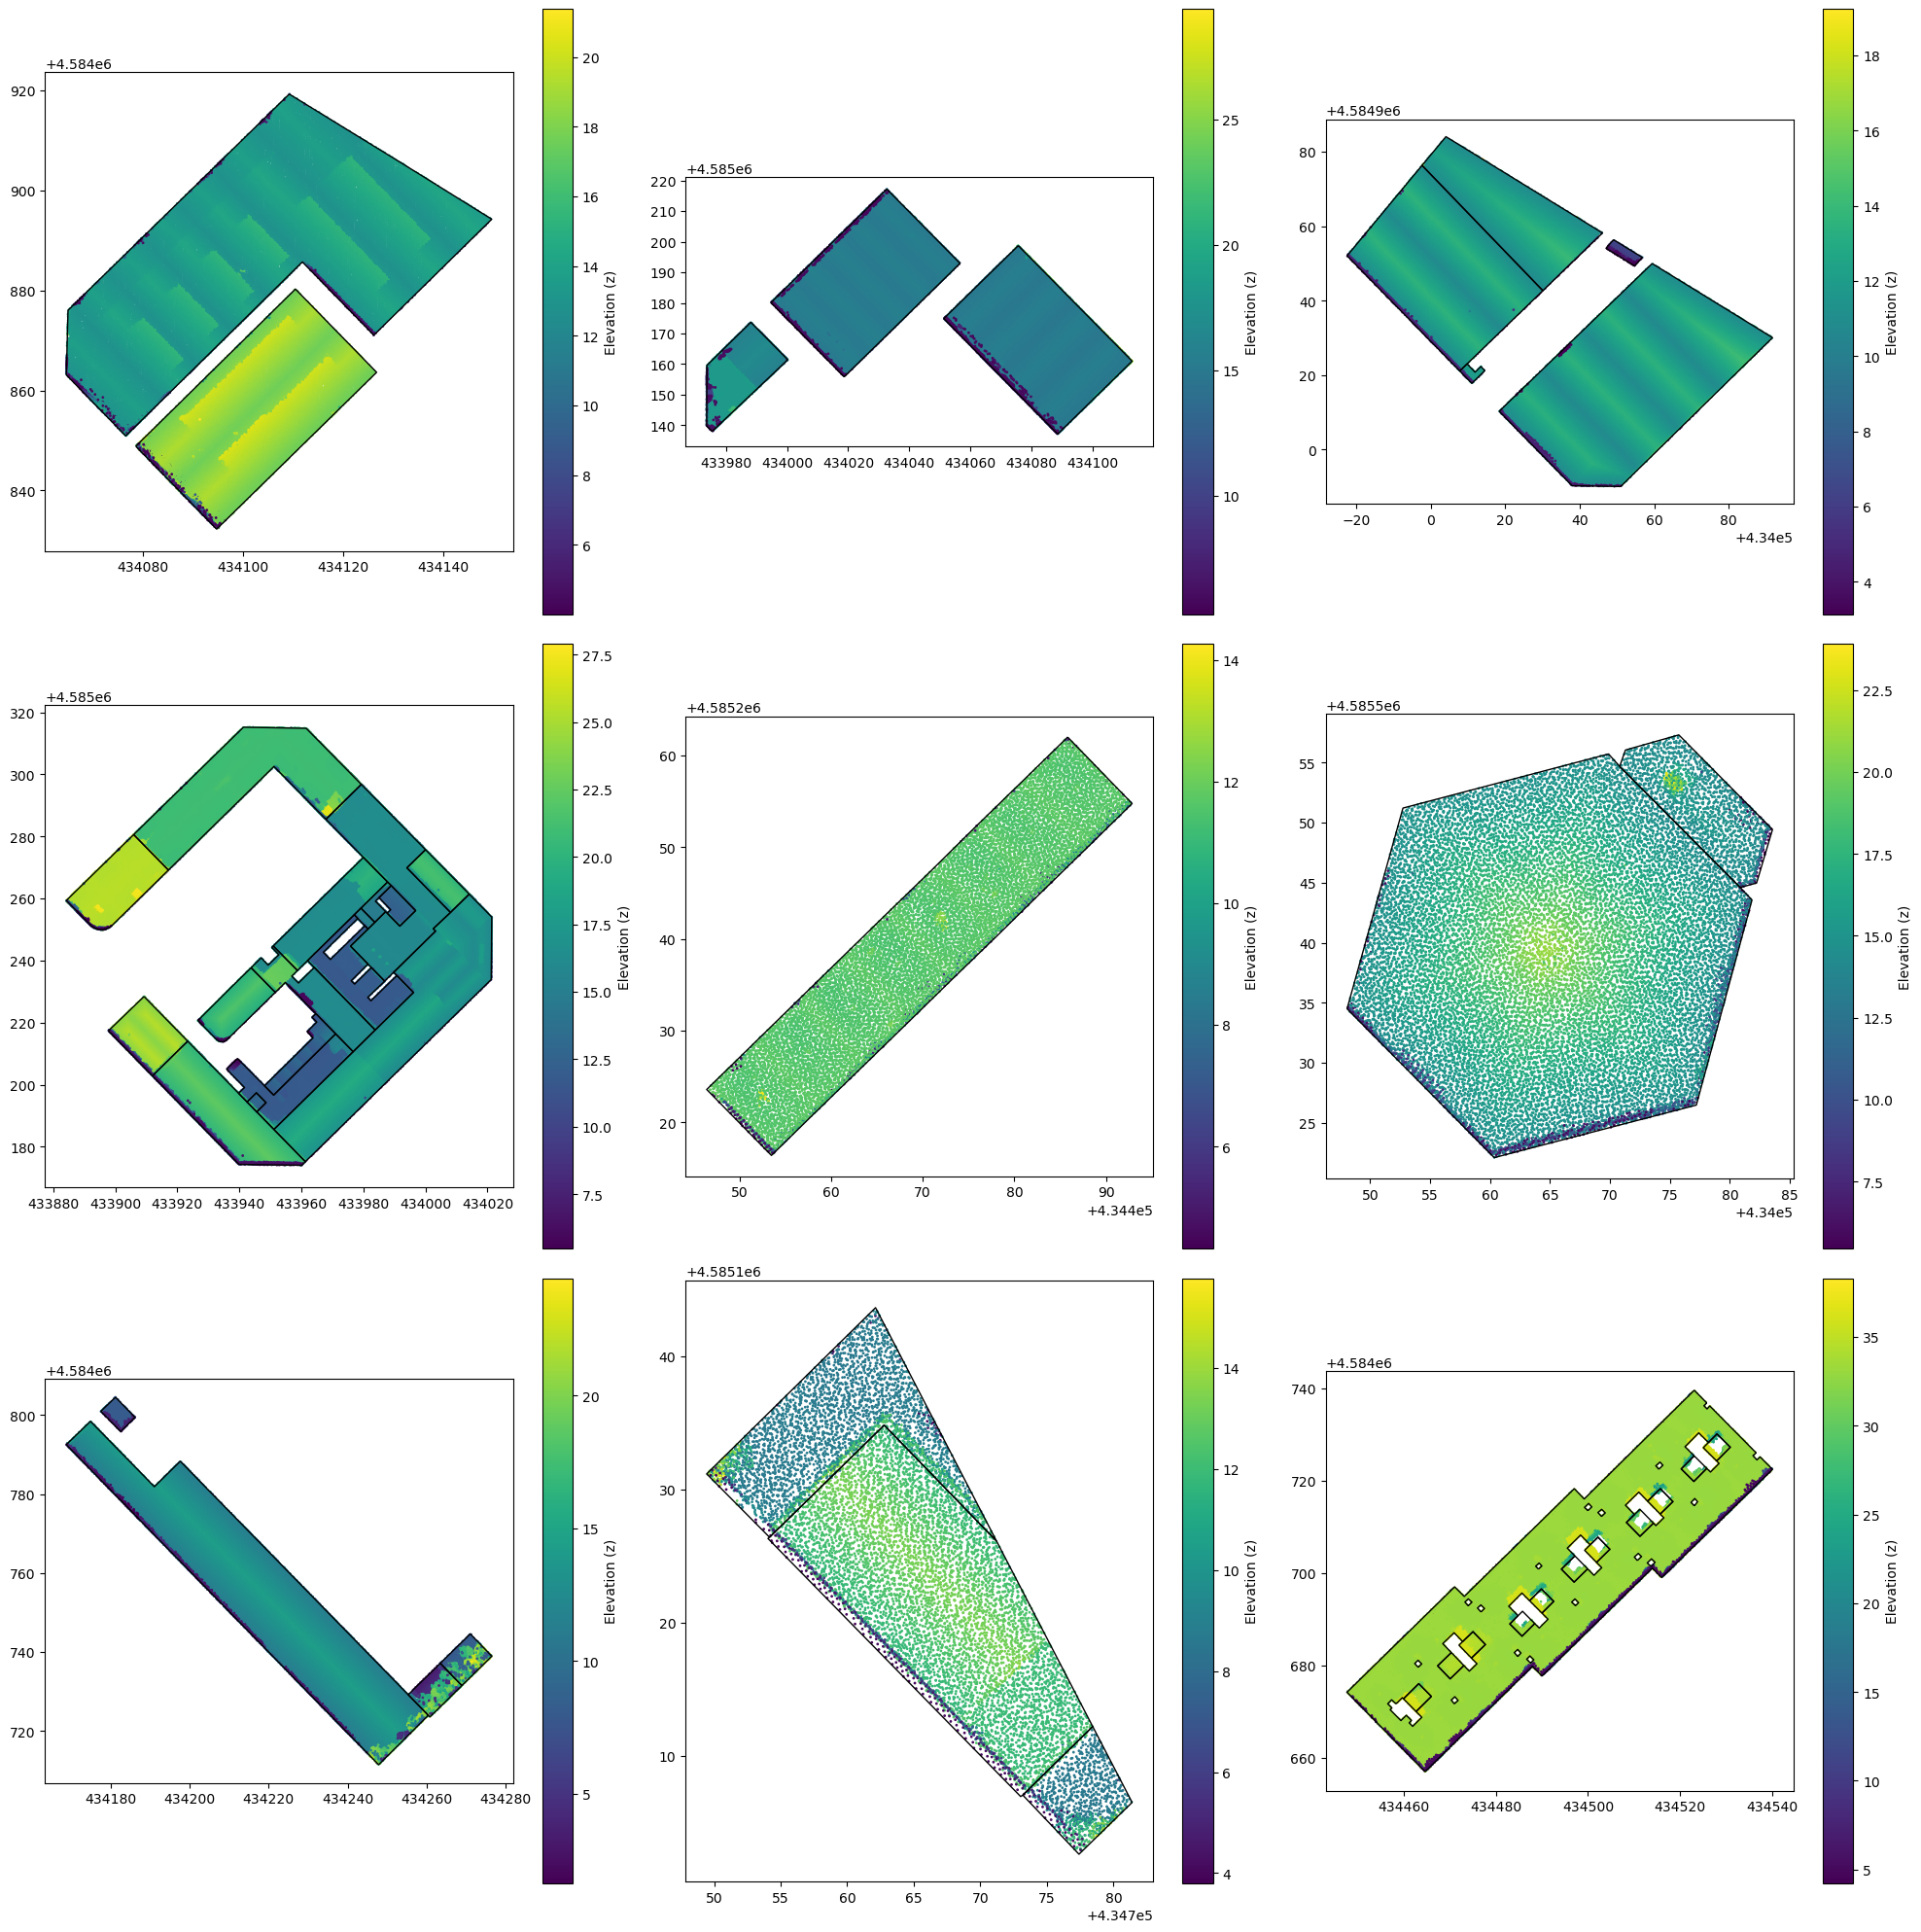

In [39]:
basePath = "/home/jaumeasensio/Documents/Projectes/BEEGroup/solar_potencial_estimation_v3/"
neighborhood = "Test_70_el Besòs i el Maresme"
parcelsFolder = basePath + "/Results/" + neighborhood + "/Parcels/"

fig, axs = plt.subplots(3, 3, figsize=(20,20))

folders = os.listdir(parcelsFolder)

for i in range(len(folders)):
    subfolder = parcelsFolder + "/" + folders[i] + "/"
    fullDF = []
    for construction in [x for x in os.listdir(subfolder) if os.path.isdir(subfolder + x)]:
        lazFile = subfolder + construction + "/Map files/" + construction + ".laz"
      
        lasDF = laspy.read(lazFile)
        x, y, z = lasDF.xyz[:,0], lasDF.xyz[:,1], lasDF.xyz[:,2]

        fullDF.append((x, y, z))

    x, y, z = np.hstack([arr[0] for arr in fullDF]), np.hstack([arr[1] for arr in fullDF]), np.hstack([arr[2] for arr in fullDF])

    ax = axs[i // 3, i % 3]
    scatter = ax.scatter(x, y, c=z, s=1, cmap='viridis')
    ax.set_aspect('equal')

    norm = Normalize(vmin=z.min(), vmax=z.max())
    cbar = fig.colorbar(ScalarMappable(norm=norm, cmap='viridis'), ax=ax)
    cbar.set_label('Elevation (z)')

    for construction in [x for x in os.listdir(subfolder) if os.path.isdir(subfolder + x)]:
        gpkgFile = subfolder + construction + "/Map files/" + construction + ".gpkg"
        
        cadasterGDF = gpd.read_file(gpkgFile)
        cadasterGDF.plot(ax=ax, color='none', edgecolor='black')


       
plt.tight_layout()
plt.savefig(basePath + "/Results/" + neighborhood + "/LiDAR_Data.png")
print("Saved!")
#plt.show()

In [19]:
lasDF.xyz[:,2]

array([33.944, 34.182, 34.079, 33.951, 34.386, 34.399, 34.217, 34.112,
       34.018, 33.962, 34.071, 34.518, 34.335, 34.194, 34.03 , 33.967,
       33.784, 33.947, 34.067, 34.223, 34.382, 34.565, 34.309, 34.227,
       34.096, 33.964, 33.882, 34.012, 34.163, 34.303, 34.388, 34.398,
       34.278, 34.174, 34.   , 33.904, 33.817, 33.995, 34.142, 34.306,
       34.348, 34.281, 34.103, 34.059, 33.907, 33.851, 34.024, 34.088,
       34.353, 34.496, 34.38 , 34.259, 34.133, 34.045, 33.837, 34.013,
       34.132, 34.267, 34.366, 34.35 , 34.277, 34.16 , 33.999, 33.816,
       33.887, 34.021, 34.155, 34.311, 34.335, 34.525, 34.349, 33.541,
       33.277, 33.172, 33.855, 34.022, 34.211, 34.408, 33.089, 33.13 ,
       33.133, 33.713, 33.77 , 33.104, 34.172, 33.079, 33.154, 33.129,
       33.128, 33.115, 33.808, 33.957, 34.071, 33.941, 33.943, 34.045,
       34.179, 34.104, 34.318, 33.97 , 34.034, 34.01 , 34.098, 34.142,
       34.152, 34.294, 34.406, 33.292, 33.961, 33.168, 34.06 , 34.285,
      